# **1️⃣ Load & Explore Data**

In [ ]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import timedelta
from scipy.interpolate import CubicSpline
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss

df = pd.read_csv('C:/Users/hamid/Downloads/Nat_Gas.csv')
df['Dates']=pd.to_datetime(df['Dates'])
df=df.sort_values('Dates')
df.head()


,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [2]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# JPMorgan quant desk style: clean, minimalistic
plt.style.use("seaborn-v0_8-whitegrid")

mpl.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "grid.alpha": 0.3,
    "grid.color": "#b0b0b0",
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6,
})

palette = sns.color_palette("deep")


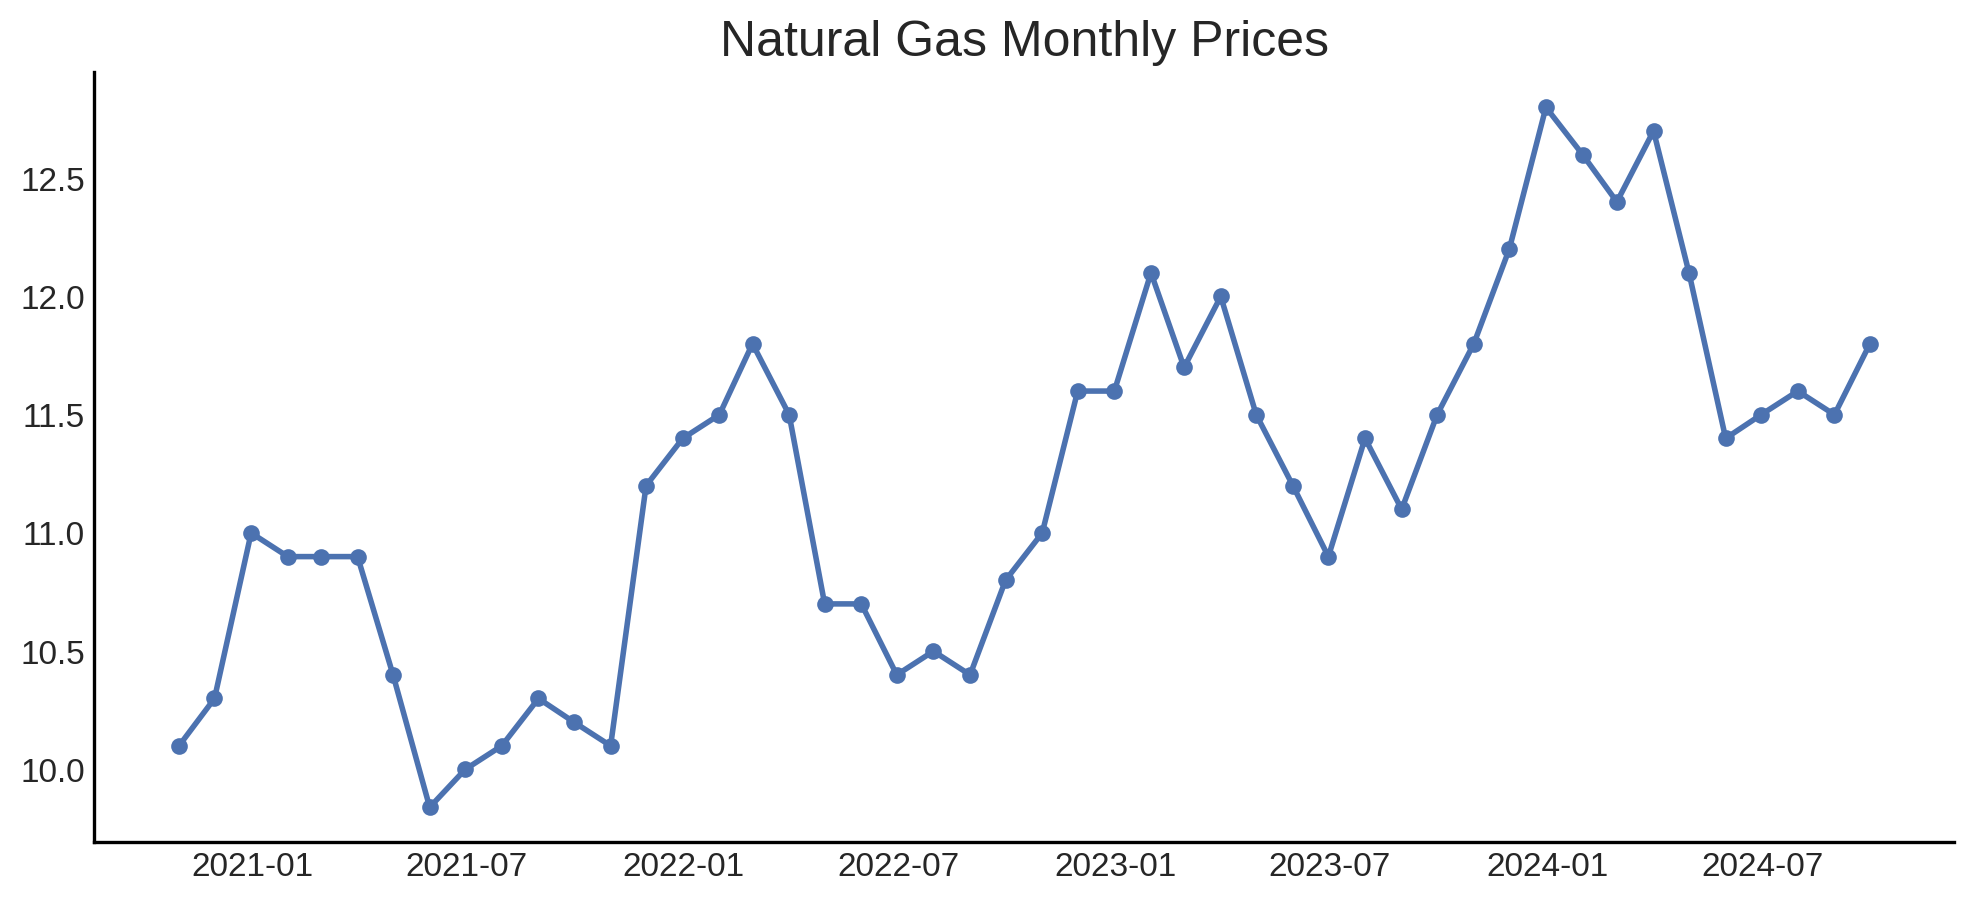

In [3]:

plt.figure(figsize=(12,5))
plt.plot(df['Dates'], df['Prices'], marker='o', color=palette[0])
plt.title("Natural Gas Monthly Prices")
plt.grid(); plt.show()


# **2️⃣ Seasonal Decomposition (STL)**

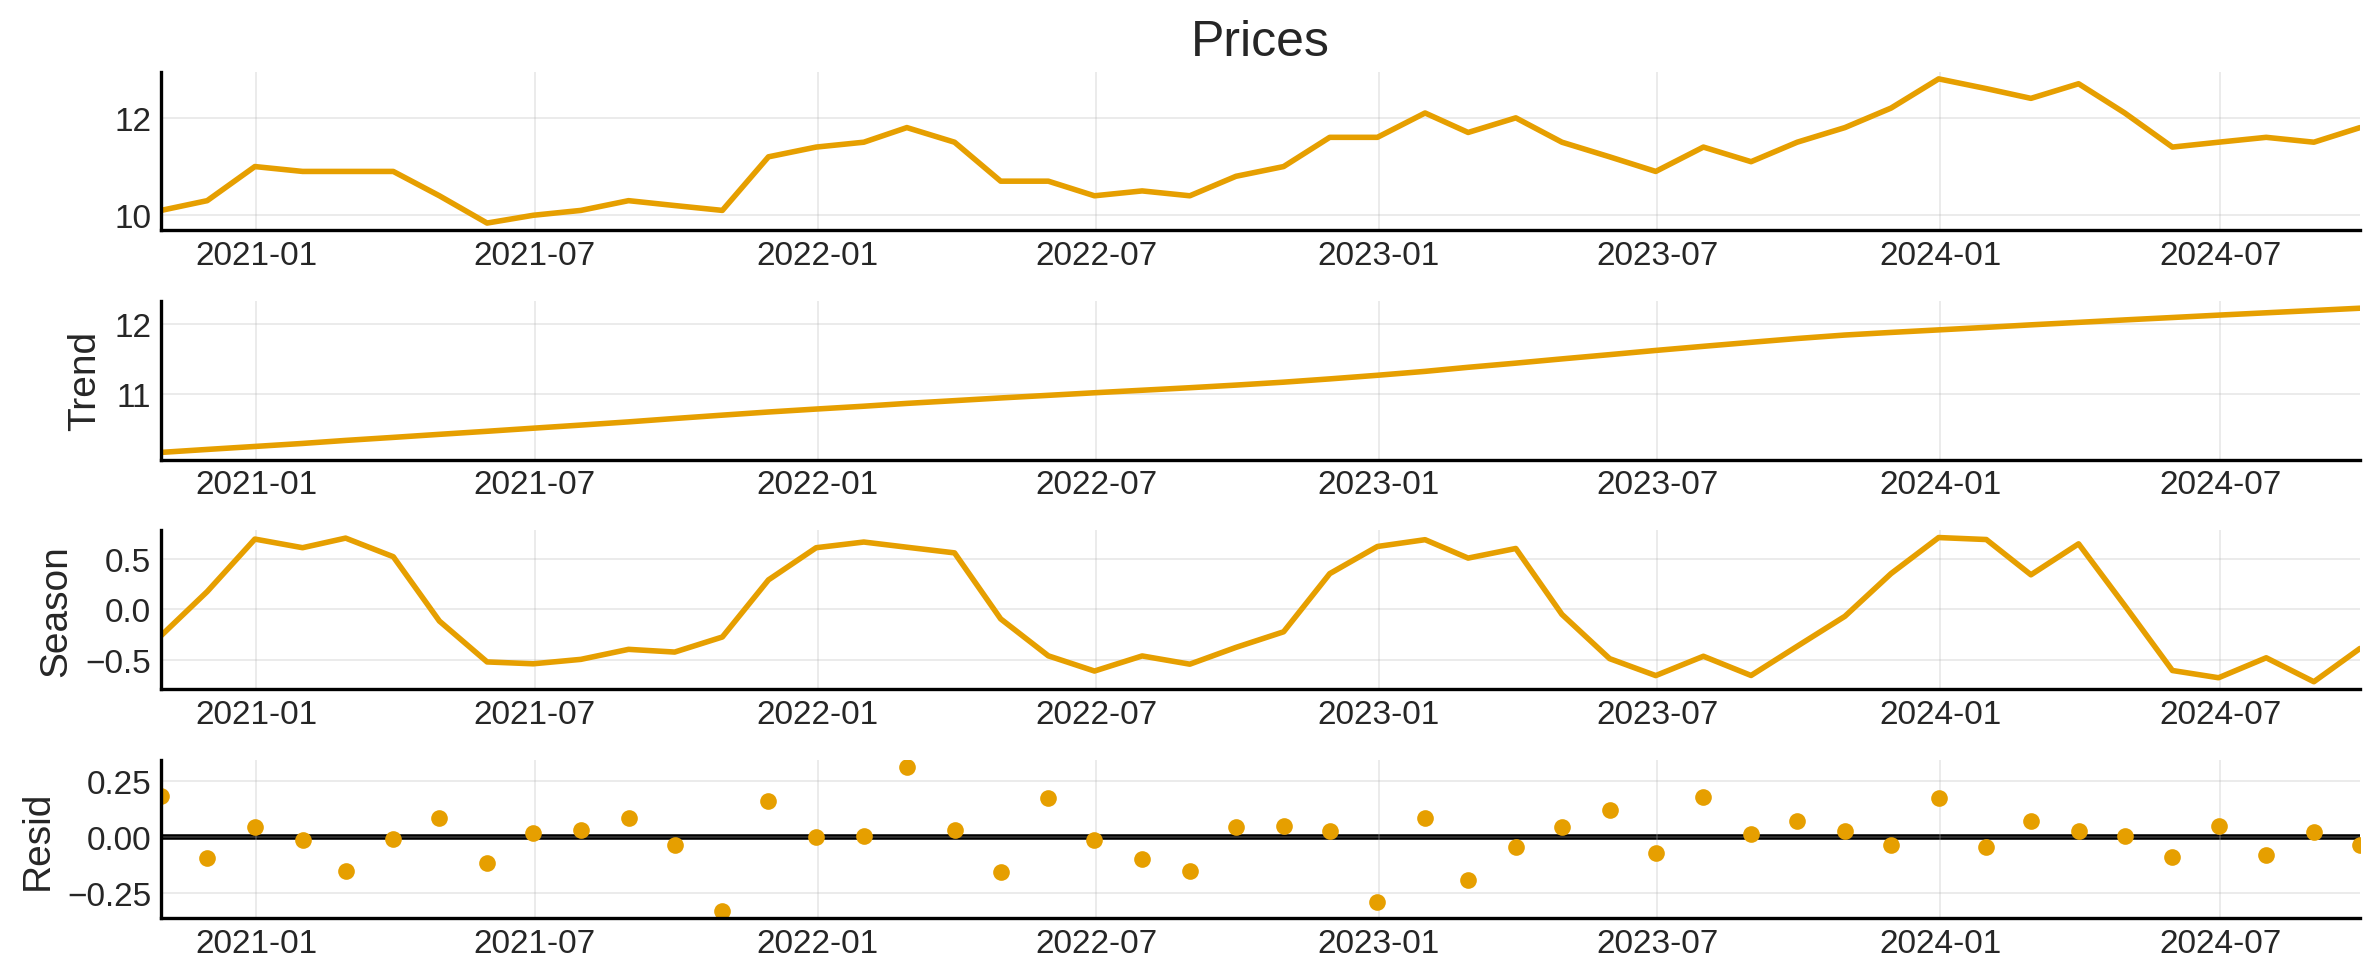

In [4]:

df_m=df.set_index('Dates').asfreq('M')
stl=STL(df_m['Prices'], period=12).fit()
df_m['Trend']=stl.trend
df_m['Seasonal']=stl.seasonal
df_m['Resid']=stl.resid
stl.plot(); plt.show()


# **3️⃣ Statistical Tests & Analysis**

In [5]:

print("ADF:", adfuller(df_m['Prices'].dropna()))
print("KPSS:", kpss(df_m['Prices'].dropna(), regression='c'))


ADF: (0.21807686169999507, 0.973257438844869, 10, 37, {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}, 10.198475035166425)
KPSS: (0.7304095231737717, 0.010780952438748024, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/home/sandbox/.local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


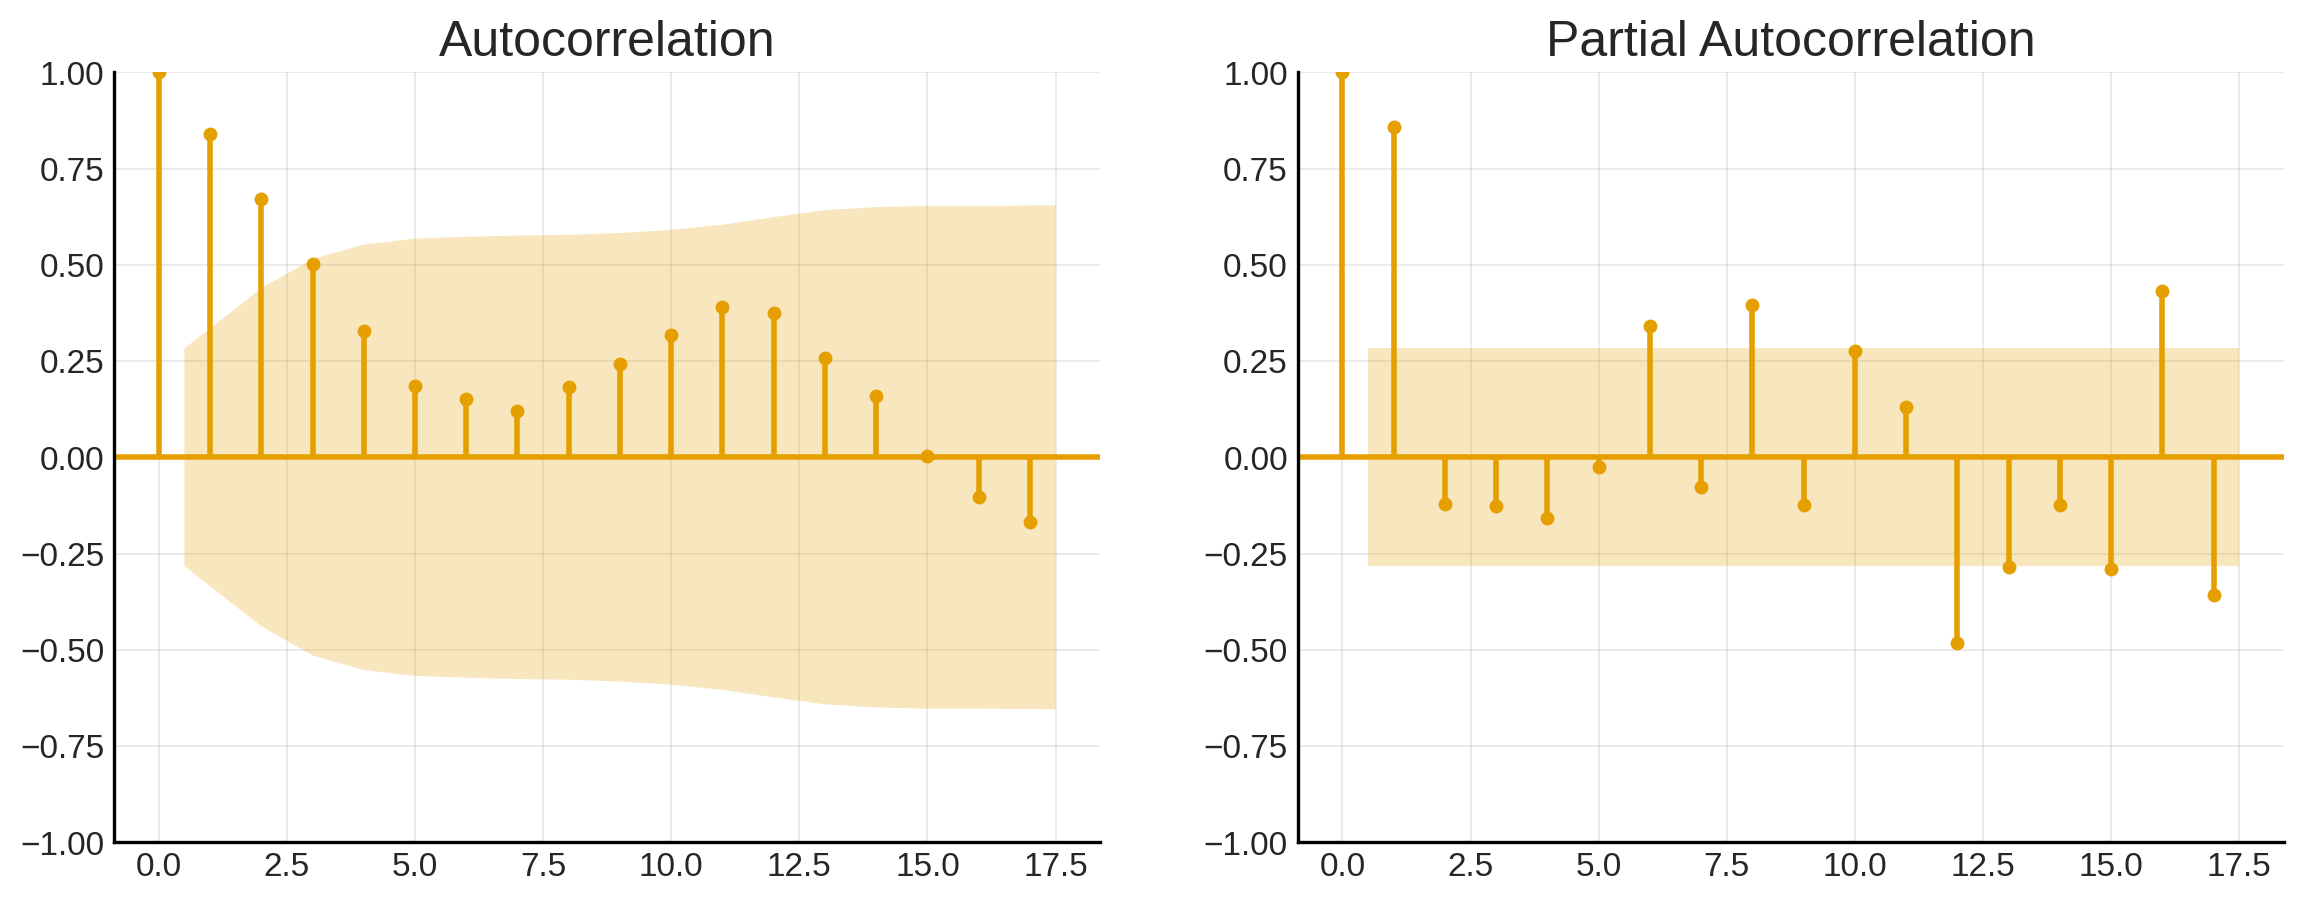

In [6]:

fig,ax=plt.subplots(1,2,figsize=(14,5))
plot_acf(df_m['Prices'], ax=ax[0]); plot_pacf(df_m['Prices'],ax=ax[1])
plt.show()


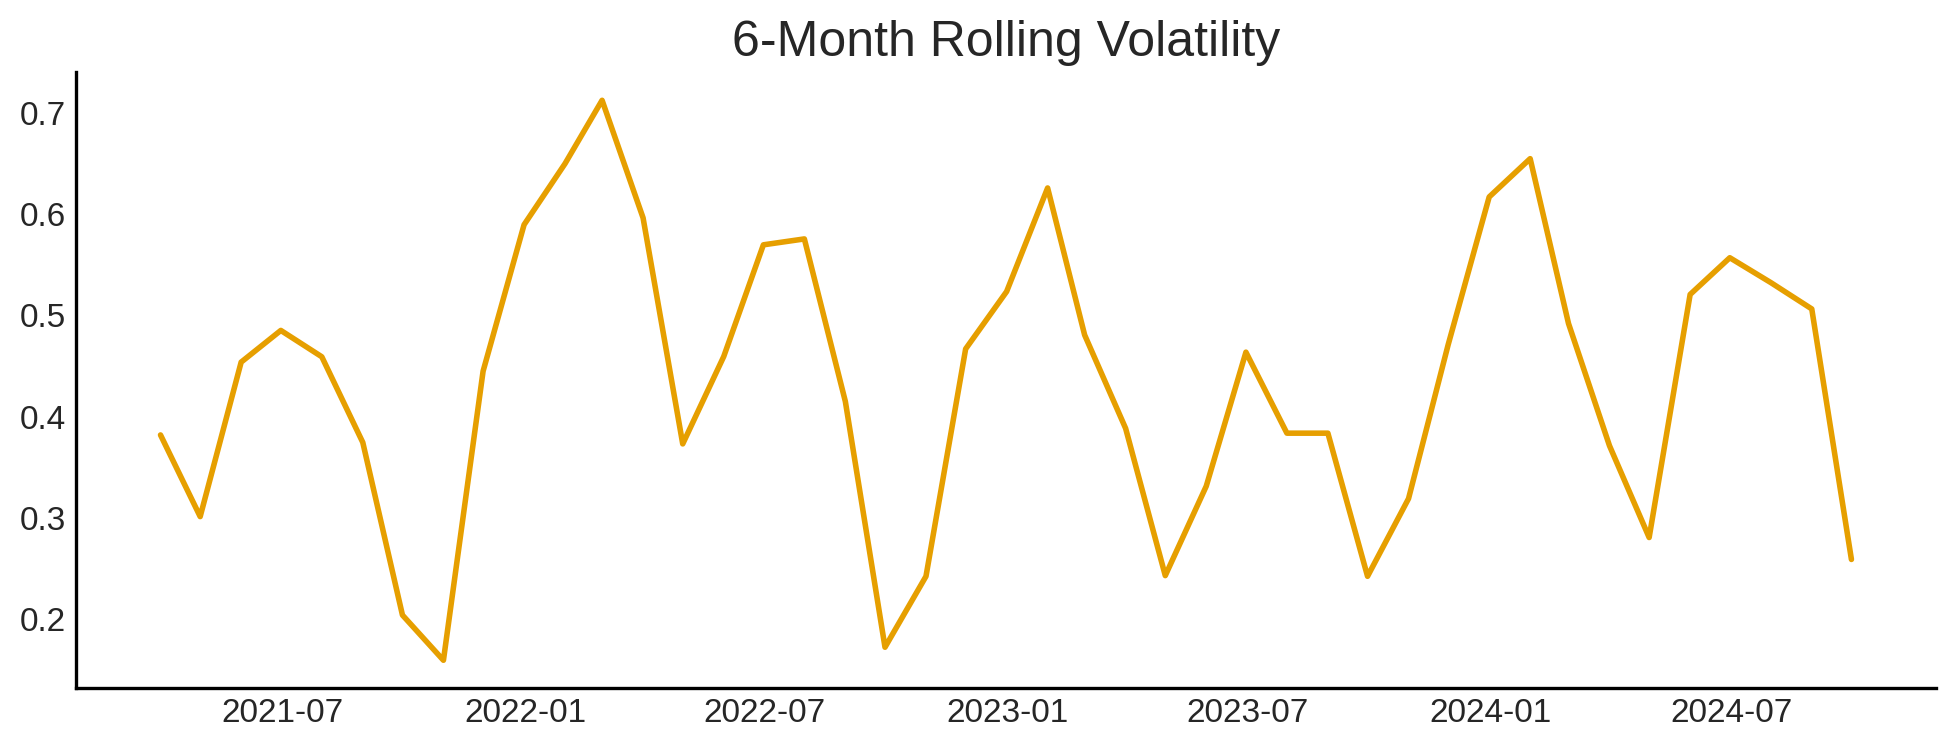

In [7]:

df_m['RollVol']=df_m['Prices'].rolling(6).std()
plt.figure(figsize=(12,4))
plt.plot(df_m['RollVol']); plt.title("6-Month Rolling Volatility")
plt.grid(); plt.show()


# **4️⃣ Time-Series Forecasting (ETS & ARIMA)**

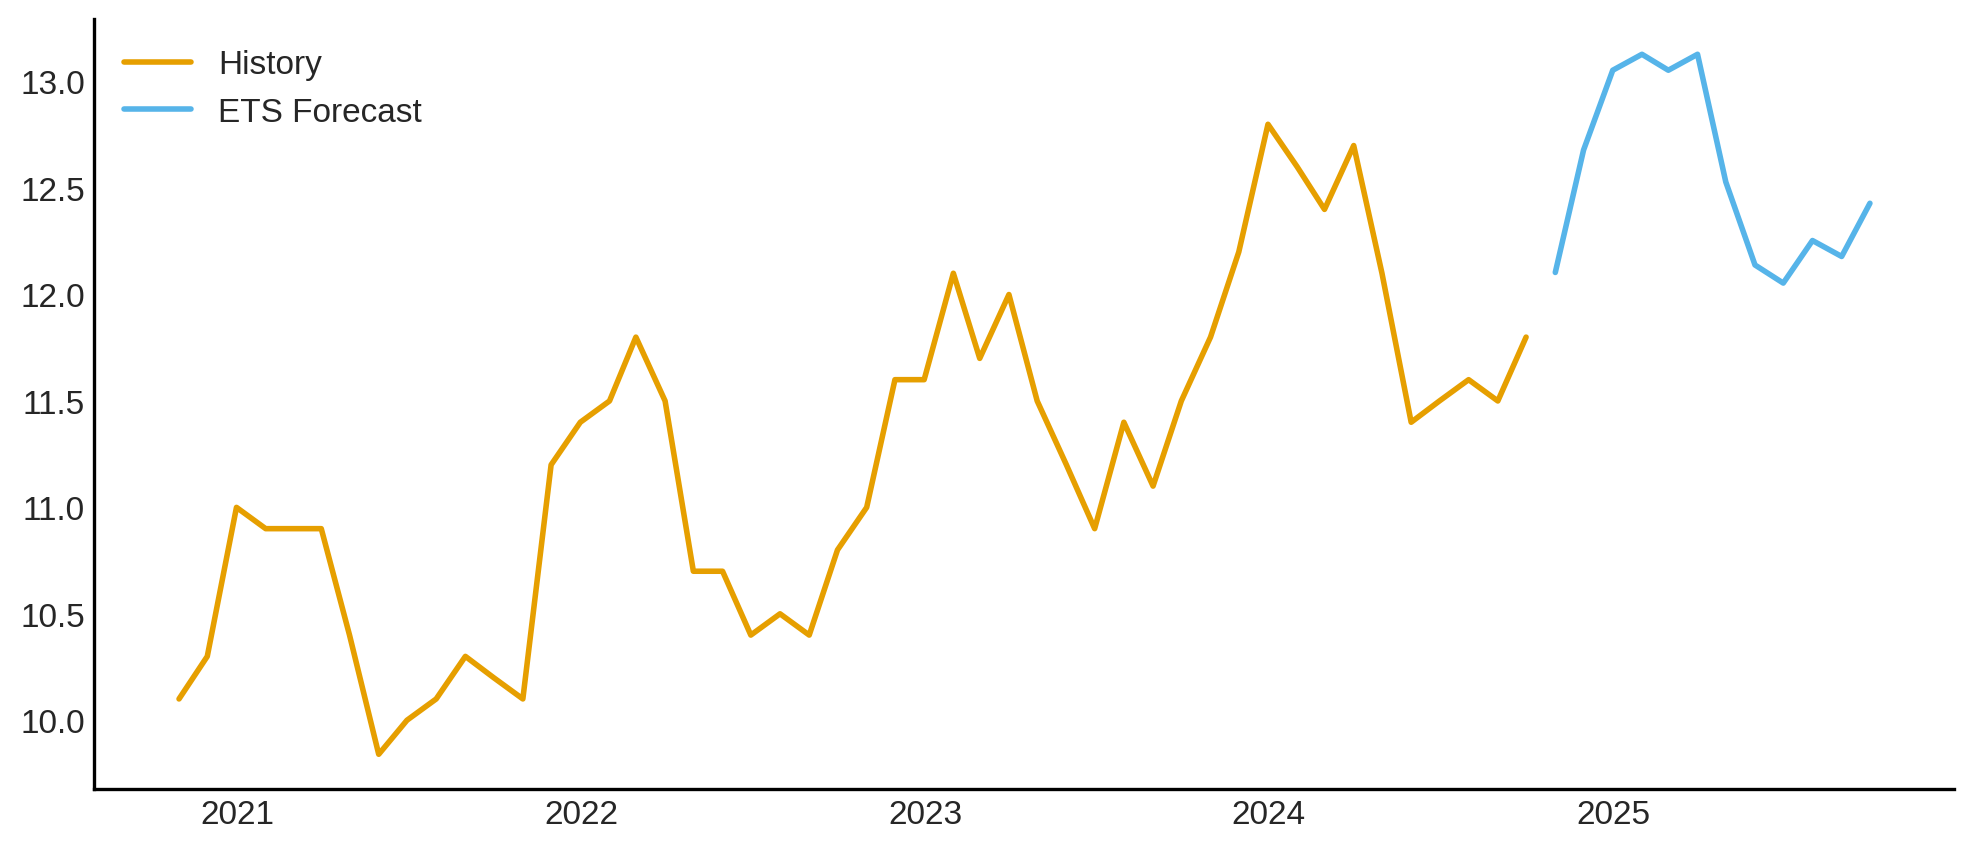

In [8]:

ets=ExponentialSmoothing(df_m['Prices'],trend='add',seasonal='add',seasonal_periods=12).fit()
ets_fc=ets.forecast(12)

plt.figure(figsize=(12,5))
plt.plot(df_m['Prices'],label='History')
plt.plot(ets_fc,label='ETS Forecast')
plt.legend(); plt.grid(); plt.show()


/home/sandbox/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sandbox/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/home/sandbox/.local/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


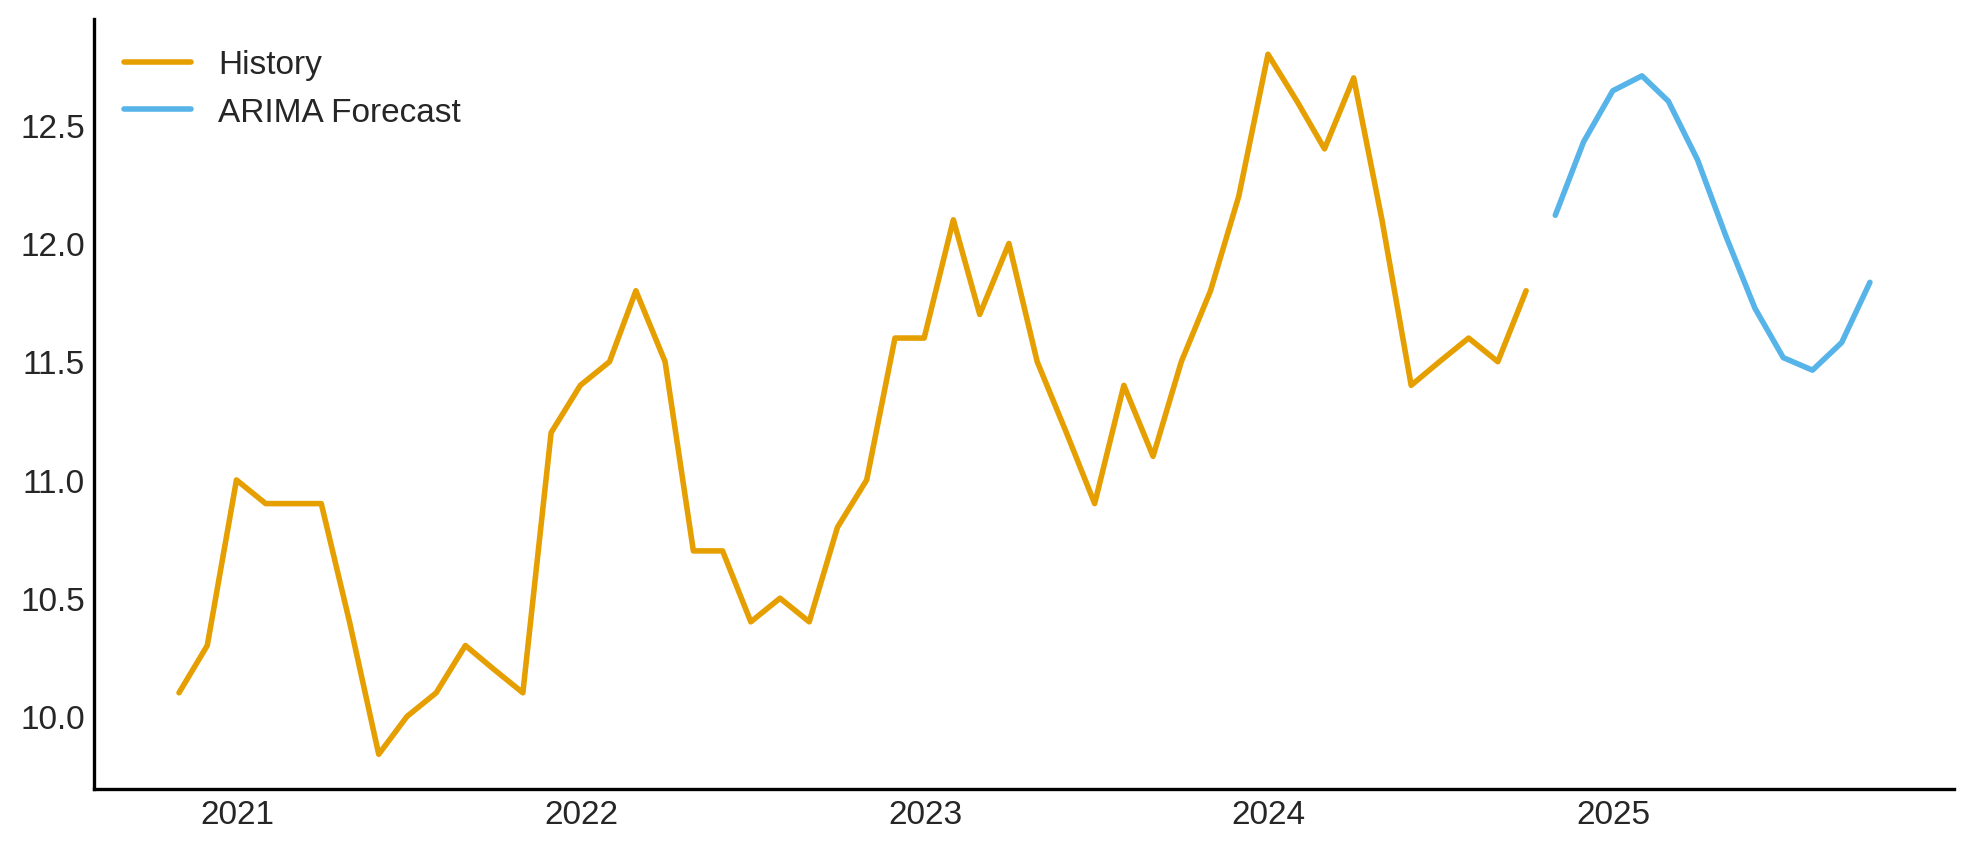

In [9]:

ar=ARIMA(df_m['Prices'],order=(2,1,2)).fit()
ar_fc=ar.forecast(12)

plt.figure(figsize=(12,5))
plt.plot(df_m['Prices'],label='History')
plt.plot(ar_fc,label='ARIMA Forecast')
plt.legend(); plt.grid(); plt.show()


# **5️⃣ Forward Curve Construction**

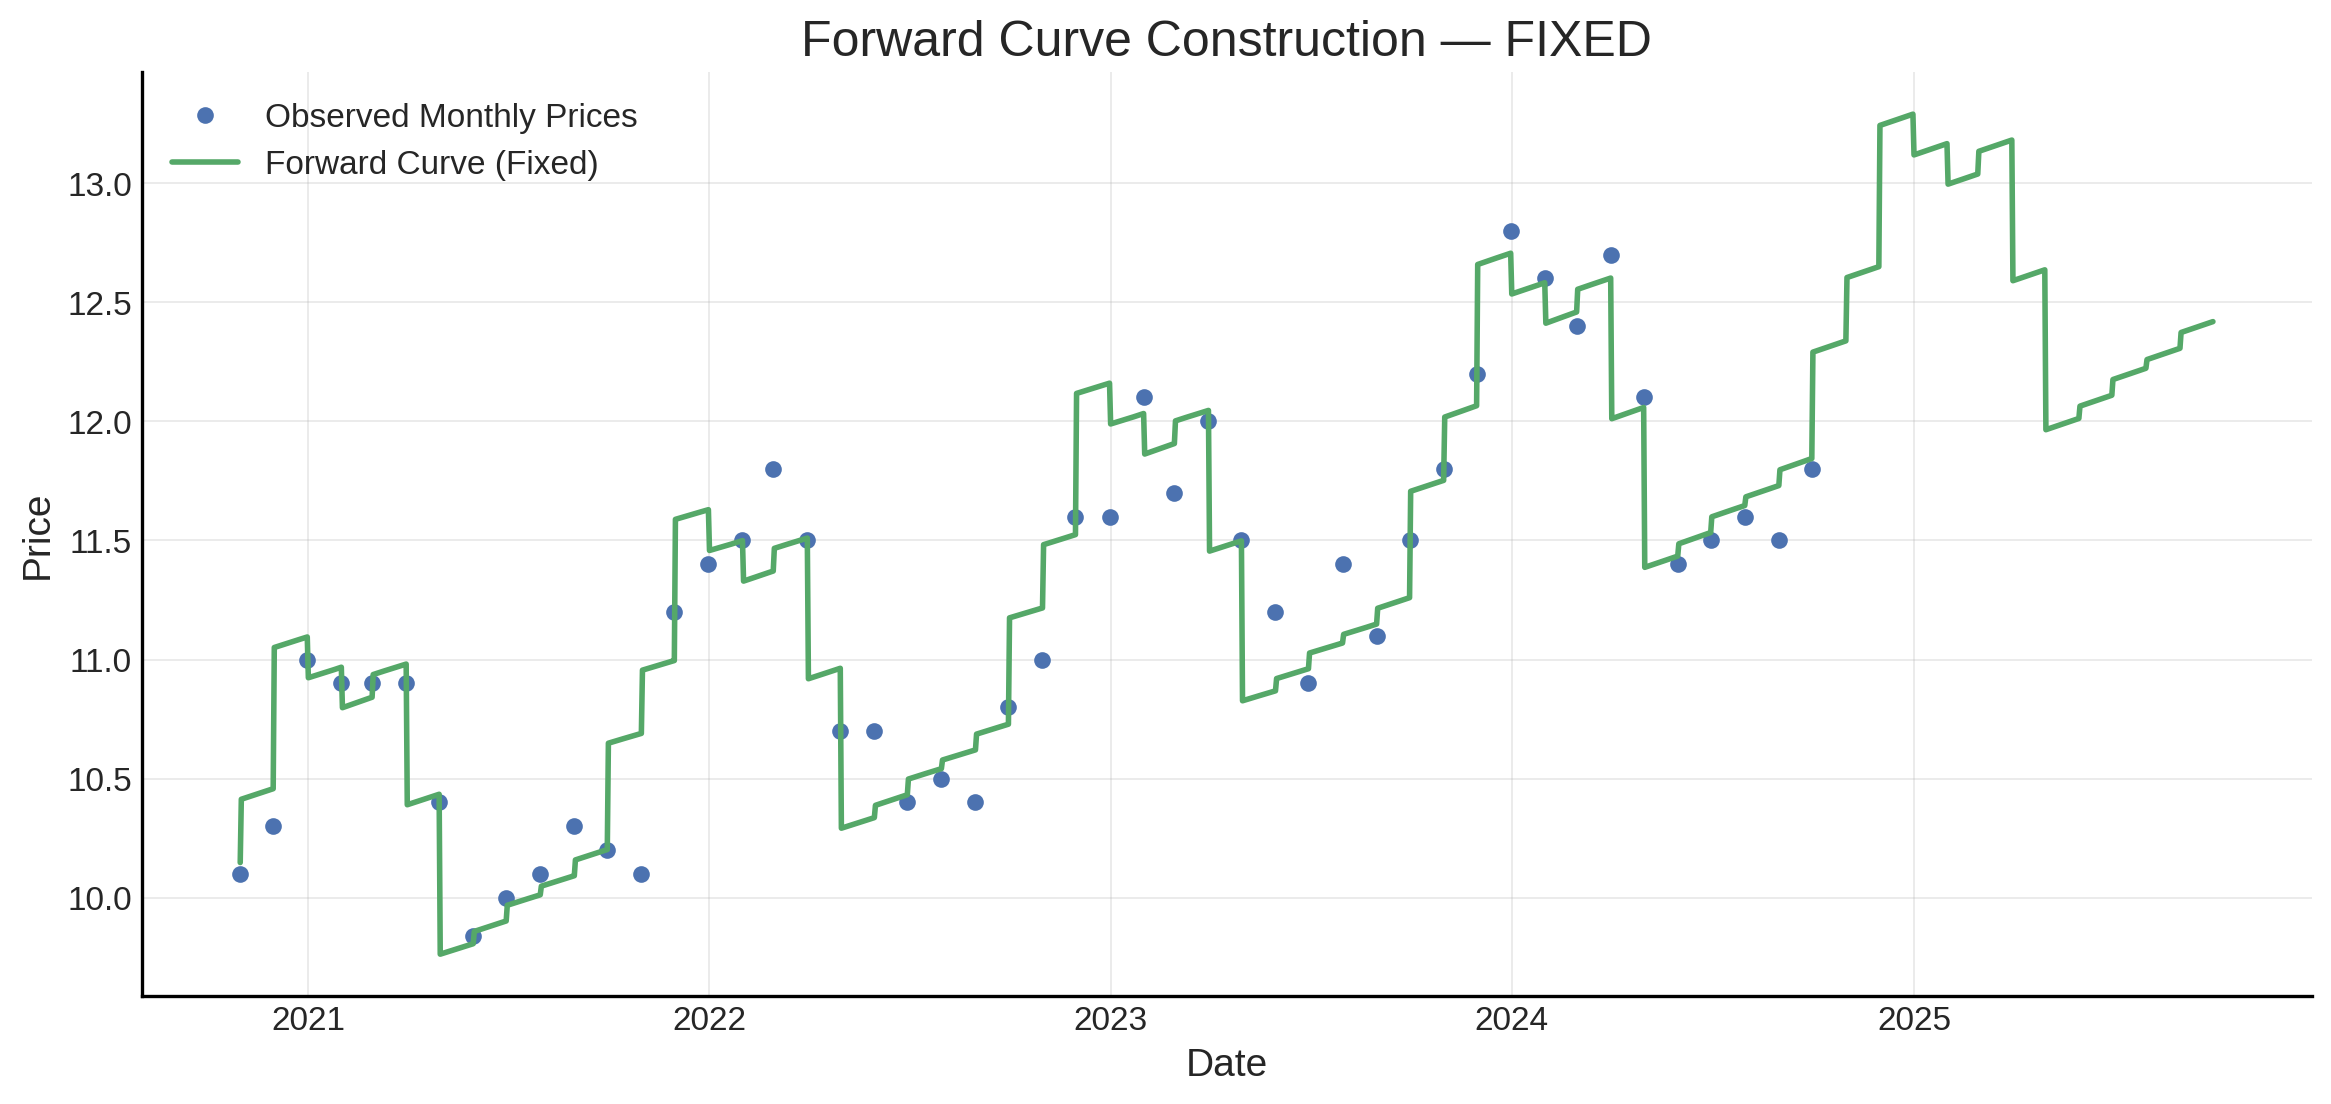

In [10]:

# ----- FIXED FORWARD CURVE CONSTRUCTION -----

df_m = df.set_index('Dates').asfreq('M')

# Re-run STL cleanly on corrected dates
stl = STL(df_m['Prices'], period=12, robust=True).fit()
df_m['Trend'] = stl.trend
df_m['Seasonal'] = stl.seasonal
df_m['Resid'] = stl.resid

# Daily interpolation
daily_idx = pd.date_range(df_m.index.min(), df_m.index.max(), freq='D')

trend_spline = CubicSpline(
    df_m.index.to_julian_date(),
    df_m['Trend']
)

daily_trend = trend_spline(daily_idx.to_julian_date())

# 1-year extrapolation
extend_until = daily_idx.max() + timedelta(days=365)
ext_idx = pd.date_range(daily_idx.min(), extend_until, freq='D')

slope = (daily_trend[-1] - daily_trend[-30]) / 30
extra_len = len(ext_idx) - len(daily_idx)
extra = daily_trend[-1] + slope * np.arange(1, extra_len + 1)

trend_ext = np.concatenate([daily_trend, extra])

# Rebuild seasonal component from corrected monthly data
seasonal_lookup = df_m['Seasonal'].groupby(df_m.index.month).mean()
seasonal_ext = np.array([seasonal_lookup[d.month] for d in ext_idx])

curve = trend_ext + seasonal_ext

plt.figure(figsize=(14,6))
plt.plot(df['Dates'], df['Prices'], marker='o', linestyle='none', color=palette[0], label='Observed Monthly Prices')
plt.plot(ext_idx, curve, color=palette[2], label='Forward Curve (Fixed)')
plt.title("Forward Curve Construction — FIXED")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(True); plt.legend()
plt.show()


# **6️⃣ Ornstein–Uhlenbeck (OU) Calibration**

In [11]:

series=df_m['Resid'].dropna().values
dt=1/12
x=series
dx=np.diff(x)
theta=np.mean(x)
kappa=-np.sum((x[:-1]-theta)*dx)/np.sum((x[:-1]-theta)**2)
sigma=np.sqrt(np.sum((dx + kappa*(x[:-1]-theta))**2)/len(dx))
kappa,theta,sigma


(1.2097094498184935, -0.008695684237465843, 0.18221641951800274)

# **7️⃣ Monte Carlo Simulation (OU Only)**

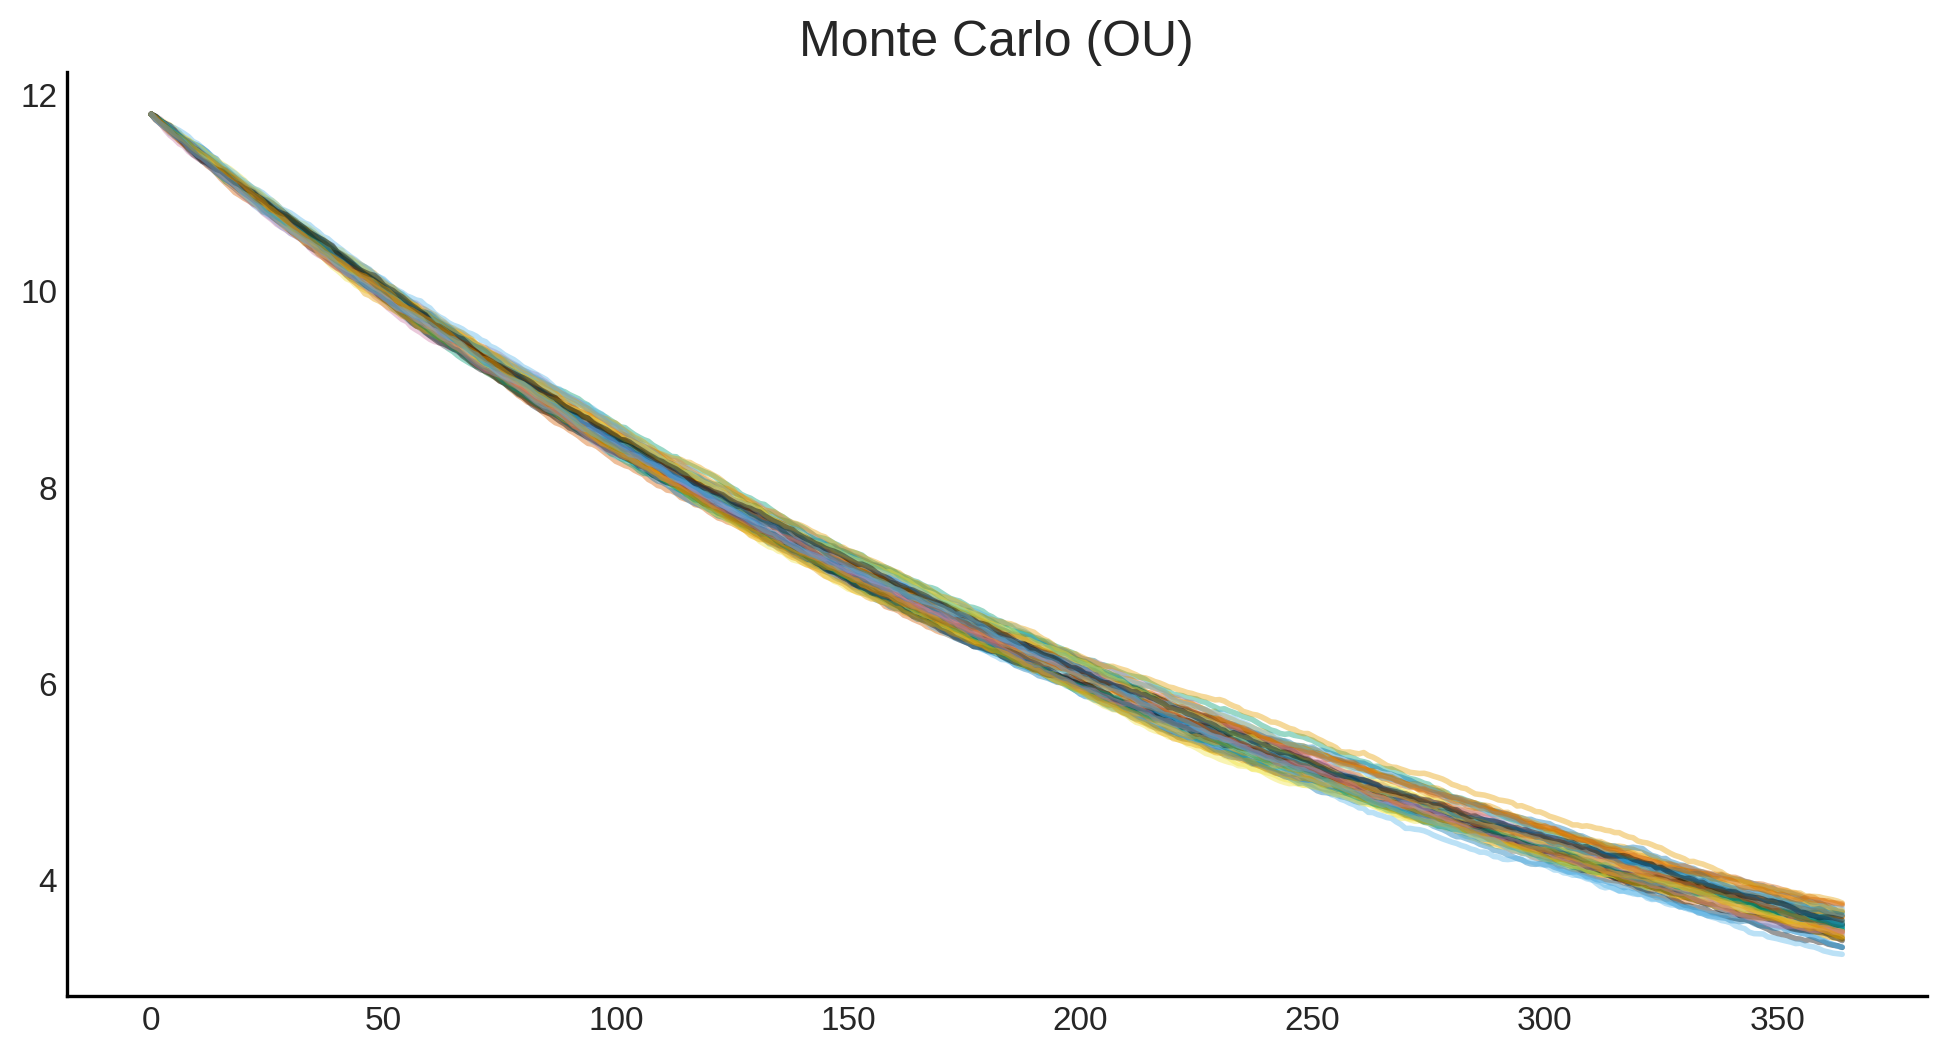

In [12]:

np.random.seed(42)
N=300
horizon=365
dt=1/365

paths=np.zeros((N,horizon))
paths[:,0]=df_m['Prices'].iloc[-1]

for t in range(1,horizon):
    z=np.random.normal(size=N)
    paths[:,t]=paths[:,t-1] + kappa*(theta-paths[:,t-1])*dt + sigma*np.sqrt(dt)*z

plt.figure(figsize=(12,6))
plt.plot(paths[:50].T,alpha=0.4)
plt.title("Monte Carlo (OU)")
plt.grid(); plt.show()


# **8️⃣ Storage Optionality Valuation**

In [13]:

intrinsic=curve.max()-curve.min()
extrinsic=np.mean(paths.max(axis=1)-paths.min(axis=1))
intrinsic,extrinsic,intrinsic+extrinsic


(3.525935442658504, 8.277408137972568, 11.803343580631072)

# **9️⃣ Price Estimation Function**

In [14]:

def estimate_price(date):
    d=pd.to_datetime(date)
    if d<ext_idx.min() or d>ext_idx.max():
        raise ValueError("Date out of range.")
    idx=np.searchsorted(ext_idx,d)
    return float(curve[idx])

estimate_price("2025-06-15")


12.08558260458053